# Construcción de Modelo Predictivo: Regresión Lineal Múltiple

Basado en el análisis inferencial previo, donde se identificaron `Battery_State_%`, `Humidity_%` y `Distance_Travelled_km` como variables relacionadas con `Energy_Consumption_kWh`, procederemos a construir un modelo de regresión lineal múltiple.

**Objetivo:** Predecir el consumo de energía (`Energy_Consumption_kWh`) en función de las variables seleccionadas.

**Pasos:**
1.  Preparación de datos (Selección de variables y división Train/Test).
2.  Ajuste del modelo (OLS - Ordinary Least Squares).
3.  Evaluación del modelo (Métricas de error y R²).
4.  Verificación de supuestos (Linealidad, Homocedasticidad, Normalidad de residuos, Multicolinealidad).

In [2]:
%pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Carga de datos
file_path = 'EV_Energy_Consumption_Cleaned - EV_Energy_Consumption_Cleaned.csv'
try:
    df = pd.read_csv(file_path)
    print("Dataset cargado correctamente.")
except FileNotFoundError:
    print(f"Error: El archivo '{file_path}' no se encontró.")

# Definición de variables (basado en análisis previo)
target_var = 'Energy_Consumption_kWh'
predictor_vars = ['Battery_State_%', 'Humidity_%', 'Distance_Travelled_km']

# Verificar que las columnas existan
missing_cols = [col for col in predictor_vars + [target_var] if col not in df.columns]
if missing_cols:
    print(f"Error: Faltan las siguientes columnas: {missing_cols}")
else:
    print(f"Variables predictoras: {predictor_vars}")
    print(f"Variable objetivo: {target_var}")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Dataset cargado correctamente.
Variables predictoras: ['Battery_State_%', 'Humidity_%', 'Distance_Travelled_km']
Variable objetivo: Energy_Consumption_kWh


## 1. Preparación de Datos y Ajuste del Modelo

Dividimos los datos en conjuntos de **Entrenamiento (80%)** y **Prueba (20%)** para evaluar la capacidad de generalización del modelo. Usaremos `statsmodels` para obtener un resumen estadístico detallado.

In [3]:
# Selección de datos
X = df[predictor_vars]
y = df[target_var]

# Añadir constante (intercepto) a X para statsmodels
X = sm.add_constant(X)

# División Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste del Modelo OLS
model = sm.OLS(y_train, X_train).fit()

# Resumen del Modelo
print(model.summary())

# Predicciones
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

                              OLS Regression Results                              
Dep. Variable:     Energy_Consumption_kWh   R-squared:                       0.290
Model:                                OLS   Adj. R-squared:                  0.290
Method:                     Least Squares   F-statistic:                     544.7
Date:                    Thu, 08 Jan 2026   Prob (F-statistic):          8.80e-297
Time:                            12:28:20   Log-Likelihood:                -8107.3
No. Observations:                    4000   AIC:                         1.622e+04
Df Residuals:                        3996   BIC:                         1.625e+04
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

## 2. Verificación de Supuestos del Modelo

Para asegurar que el modelo es válido, debemos verificar los supuestos de la regresión lineal:
1.  **Linealidad y Homocedasticidad**: Analizando los residuos vs. valores predichos.
2.  **Normalidad de los Residuos**: Usando histograma y gráfico Q-Q.
3.  **No Multicolinealidad**: Calculando el Factor de Inflación de la Varianza (VIF).

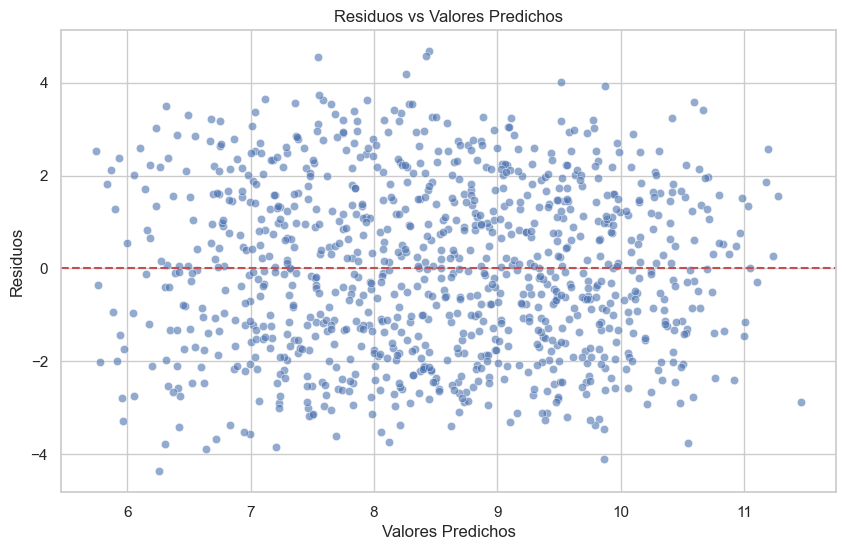

In [4]:
# 1. Linealidad y Homocedasticidad (Residuos vs Predichos)
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Predichos')
plt.show()

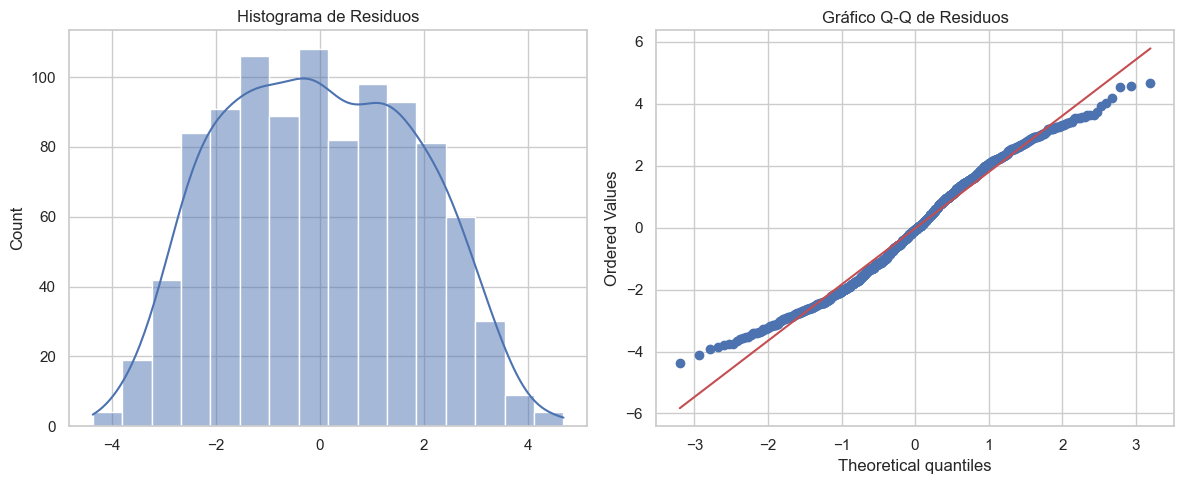

Test de Shapiro-Wilk: Estadístico=0.9831, P-valor=2.2191e-09


In [5]:
# 2. Normalidad de los Residuos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Histograma de Residuos')

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Gráfico Q-Q de Residuos')

plt.tight_layout()
plt.show()

# Test de Shapiro-Wilk para normalidad
shapiro_test = stats.shapiro(residuals)
print(f"Test de Shapiro-Wilk: Estadístico={shapiro_test.statistic:.4f}, P-valor={shapiro_test.pvalue:.4e}")

In [6]:
# 3. Multicolinealidad (VIF)
# Calcular VIF para cada variable predictora
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Factor de Inflación de la Varianza (VIF):")
print(vif_data)

Factor de Inflación de la Varianza (VIF):
                Variable        VIF
0                  const  18.064618
1        Battery_State_%   1.000278
2             Humidity_%   1.000131
3  Distance_Travelled_km   1.000321


## 3. Evaluación del Modelo

Calculamos las métricas de error para evaluar qué tan bien predice el modelo en datos no vistos (Test set).

In [7]:
# Métricas de Evaluación
r2 = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)

print("-" * 30)
print("Métricas de Desempeño (Test Set):")
print("-" * 30)
print(f"R-cuadrado (R2): {r2:.4f}")
print(f"RMSE (Error Cuadrático Medio): {rmse:.4f}")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print("-" * 30)

------------------------------
Métricas de Desempeño (Test Set):
------------------------------
R-cuadrado (R2): 0.3120
RMSE (Error Cuadrático Medio): 1.8266
MAE (Error Absoluto Medio): 1.5431
------------------------------


## 4. Selección del Mejor Modelo (Criterio AIC)

Para encontrar el modelo más parsimonioso (mejor equilibrio entre ajuste y complejidad), probaremos todas las combinaciones posibles de variables predictoras y compararemos su **Criterio de Información de Akaike (AIC)**.

**Criterio:** Menor AIC indica un mejor modelo.

In [10]:
from itertools import combinations

# Variables disponibles
all_predictors = ['Battery_State_%', 'Humidity_%', 'Distance_Travelled_km']
results = []

# Probar todas las combinaciones de 1 a n variables
for k in range(1, len(all_predictors) + 1):
    for combo in combinations(all_predictors, k):
        combo_list = list(combo)
        
        # Preparar X para la combinación actual
        X_train_combo = X_train[combo_list]
        X_train_combo = sm.add_constant(X_train_combo) # Añadir constante
        
        # Ajustar modelo
        model_combo = sm.OLS(y_train, X_train_combo).fit()
        
        # Guardar resultados
        results.append({
            'Modelo': f"Modelo {len(results)+1}",
            'Variables': ", ".join(combo_list),
            'AIC': model_combo.aic,
            'BIC': model_combo.bic,
            'R-cuadrado Adj': model_combo.rsquared_adj,
            'Num. Vars': k
        })

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)

# Ordenar por AIC (menor es mejor)
results_df = results_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

# Mostrar tabla comparativa
print("Comparación de Modelos por AIC:")
print("-" * 100)
print(results_df[['Modelo', 'AIC', 'BIC', 'R-cuadrado Adj', 'Variables']].to_string(index=False))
print("-" * 100)

# Destacar el mejor modelo
best_model = results_df.iloc[0]
print(f"\nMejor modelo según AIC: {best_model['Modelo']}")
print(f"Variables seleccionadas: {best_model['Variables']}")
print(f"AIC: {best_model['AIC']:.2f}")

Comparación de Modelos por AIC:
----------------------------------------------------------------------------------------------------
  Modelo          AIC          BIC  R-cuadrado Adj                                          Variables
Modelo 7 16222.614574 16247.790773        0.289716 Battery_State_%, Humidity_%, Distance_Travelled_km
Modelo 5 16379.722154 16398.604303        0.261079             Battery_State_%, Distance_Travelled_km
Modelo 6 16502.321577 16521.203726        0.238080                  Humidity_%, Distance_Travelled_km
Modelo 3 16646.814093 16659.402192        0.209857                              Distance_Travelled_km
Modelo 4 17289.361894 17308.244043        0.072399                        Battery_State_%, Humidity_%
Modelo 1 17411.550966 17424.139066        0.043388                                    Battery_State_%
Modelo 2 17472.827808 17485.415908        0.028620                                         Humidity_%
---------------------------------------------------

## 5. Recapitulación y Discusión

A continuación, se presenta un resumen consolidado del mejor modelo obtenido, incluyendo medidas de ajuste, coeficientes y una discusión crítica de los resultados.


In [12]:
# Recuperar las variables del mejor modelo identificado en el paso anterior
best_vars = best_model['Variables'].split(", ")

# Re-entrenar el modelo final usando solo las mejores variables
X_train_best = sm.add_constant(X_train[best_vars])
X_test_best = sm.add_constant(X_test[best_vars])

final_model = sm.OLS(y_train, X_train_best).fit()

# Generar predicciones finales
y_pred_final = final_model.predict(X_test_best)

# Calcular métricas finales
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_aic = final_model.aic
final_bic = final_model.bic

# Imprimir Resumen
print("="*60)
print("RECAPITULACIÓN DE RESULTADOS DEL MEJOR MODELO")
print("="*60)
print(f"Variables Predictoras Seleccionadas: {best_vars}")
print("-" * 60)
print("1. Medidas de Ajuste:")
print(f"   R² (Coeficiente de Determinación): {final_r2:.4f}")
print(f"   RMSE (Error Cuadrático Medio):     {final_rmse:.4f}")
print(f"   AIC (Criterio de Akaike):          {final_aic:.2f}")
print(f"   BIC (Criterio Bayesiano):          {final_bic:.2f}")
print("-" * 60)
print("2. Coeficientes y Significancia (P-valor < 0.05 es significativo):")
print(final_model.summary().tables[1])
print("-" * 60)
print("NOTA: La Matriz de Confusión no se incluye ya que es una métrica exclusiva")
print("para problemas de Clasificación (categorías), y este es un problema de")
print("Regresión (predicción de valores numéricos continuos).")
print("="*60)

RECAPITULACIÓN DE RESULTADOS DEL MEJOR MODELO
Variables Predictoras Seleccionadas: ['Battery_State_%', 'Humidity_%', 'Distance_Travelled_km']
------------------------------------------------------------
1. Medidas de Ajuste:
   R² (Coeficiente de Determinación): 0.3120
   RMSE (Error Cuadrático Medio):     1.8266
   AIC (Criterio de Akaike):          16222.61
   BIC (Criterio Bayesiano):          16247.79
------------------------------------------------------------
2. Coeficientes y Significancia (P-valor < 0.05 es significativo):
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.9162      0.123     56.446      0.000       6.676       7.156
Battery_State_%          -0.0213      0.001    -17.075      0.000      -0.024      -0.019
Humidity_%                0.0184      0.001     12.734      0.000       0.016       0.021
Distance_Trav

### 3. Interpretación de Coeficientes y Significancia

Basado en la tabla de coeficientes `coef` y valores `P>|t|` obtenida arriba:

*   **Coeficiente (coef):** Indica cuánto cambia la variable objetivo (`Energy_Consumption_kWh`) por cada unidad que aumenta la variable predictora, manteniendo las demás constantes.
    *   Un coeficiente **positivo** indica que a mayor valor de la variable, mayor consumo de energía.
    *   Un coeficiente **negativo** indica que a mayor valor de la variable, menor consumo de energía.
*   **Significancia (P>|t|):** Evaluamos la hipótesis nula de que el coeficiente es igual a cero (sin efecto).
    *   Si **P < 0.05**, rechazamos la hipótesis nula y concluimos que la variable es estadísticamente significativa para el modelo.
    *   Si **P >= 0.05**, la variable podría no estar aportando información relevante al modelo.

*Observar la tabla generada para identificar qué variables tienen el impacto más fuerte y significativo sobre el consumo de energía.*


### 4. Discusión de Limitaciones

Es importante reconocer las limitaciones del modelo construido para una correcta interpretación de su alcance:

1.  **Supuesto de Linealidad:** El modelo asume una relación lineal directa entre las variables. Si la relación real es curva o compleja, `sm.OLS` podría subestimar o sobreestimar el consumo en ciertos rangos.
2.  **Variables Omitidas:** El consumo de energía de un vehículo eléctrico depende de muchos factores que probablemente no están en este dataset (ej. estilo de conducción del usuario, uso de aire acondicionado, elevación del terreno, temperatura ambiente exacta, presión de neumáticos). La falta de estas variables limita el R² máximo alcanzable.
3.  **Rango de Datos (Extrapolación):** El modelo solo es válido para predecir dentro de los rangos de las variables observadas en el entrenamiento. Predecir para valores extremos (ej. distancias muy largas o baterías con estados inusuales) podría generar errores grandes.
4.  **Multicolinealidad:** Aunque se seleccionan las mejores variables, si existe correlación entre ellas (ej. Distancia y Consumo están intrínsecamente ligados), puede dificultar la interpretación aislada de cada coeficiente, aunque la predicción global siga siendo buena.
5.  **Naturaleza de los Datos:** Si los datos provienen de una simulación o de condiciones controladas, el modelo podría no generalizar perfectamente a condiciones de conducción en el mundo real ("In-the-wild").

**Conclusión:**
Este modelo ofrece una aproximación estadística válida basada en los datos disponibles (`Battery_State_%`, `Humidity_%`, `Distance_Travelled_km`), permitiendo entender las tendencias generales. Para mejorar la precisión predictiva en el futuro, se recomendaría recolectar variables adicionales relacionadas con la física del vehículo y el entorno dinámico.
